In [1]:
import os
import tensorflow as tf

train_dir = 'data3a/training' 
val_dir = 'data3a/validation'

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
img_width, img_height = 150, 150
batch_size = 16

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

inceptionv3_model = Sequential()
pretrained_model = InceptionV3(
    include_top=False,
    input_shape=(img_width, img_height, 3),
    pooling='max',
    classes=3,
    weights='imagenet'
)
for layer in pretrained_model.layers:
    layer.trainable=False
    
inceptionv3_model.add(pretrained_model)

inceptionv3_model.add(Flatten())
inceptionv3_model.add(Dense(512, activation='relu',))
# minor, moderate, and severe (3)
inceptionv3_model.add(Dense(3, activation='softmax'))

In [6]:
inceptionv3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 22853411 (87.18 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [7]:
#Model compile
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

inceptionv3_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import CSVLogger

# Define the CSVLogger

log_folder = "traininglog"
log_file_path = f"{log_folder}/inceptionv3_training_log.csv"

csv_logger = CSVLogger(log_file_path, append=True)

In [9]:
#Model Train 
set_epoch=50

import time 
start_time = time.time()

# Train the model and pass the CSVLogger as a callback
history = inceptionv3_model.fit(train_generator, epochs=set_epoch, validation_data=val_generator,callbacks=[csv_logger])

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total training time: {elapsed_time:.2f} seconds")

Epoch 1/50
87/87 [==============================] - 32s 313ms/step - loss: 3.0198 - accuracy: 0.4519 - val_loss: 0.9261 - val_accuracy: 0.5605
Epoch 2/50
87/87 [==============================] - 22s 254ms/step - loss: 1.0522 - accuracy: 0.5560 - val_loss: 0.7715 - val_accuracy: 0.6452
Epoch 3/50
87/87 [==============================] - 18s 212ms/step - loss: 0.9306 - accuracy: 0.5864 - val_loss: 0.8007 - val_accuracy: 0.5927
Epoch 4/50
87/87 [==============================] - 19s 214ms/step - loss: 0.9709 - accuracy: 0.5437 - val_loss: 0.8410 - val_accuracy: 0.6089
Epoch 5/50
87/87 [==============================] - 19s 213ms/step - loss: 0.9189 - accuracy: 0.5857 - val_loss: 0.8488 - val_accuracy: 0.6089
Epoch 6/50
87/87 [==============================] - 19s 215ms/step - loss: 0.8763 - accuracy: 0.5654 - val_loss: 0.7221 - val_accuracy: 0.6935
Epoch 7/50
87/87 [==============================] - 20s 228ms/step - loss: 0.8682 - accuracy: 0.5871 - val_loss: 0.7379 - val_accuracy: 0.6653

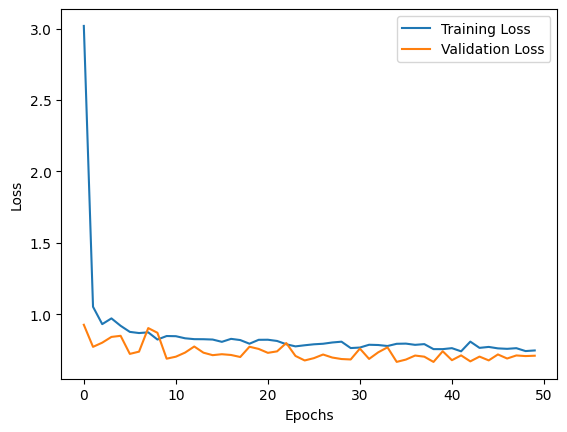

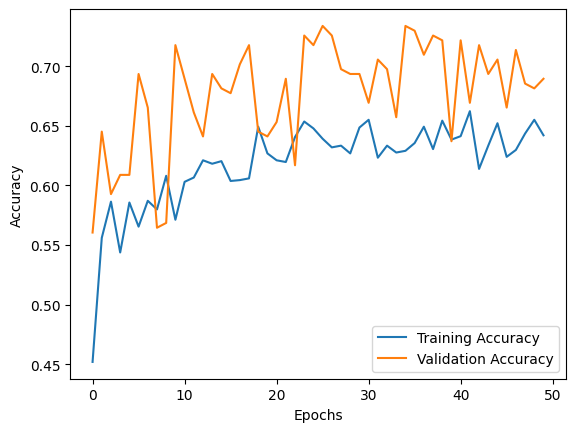

In [10]:
import matplotlib.pyplot as plt

# loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


8/8 [==============================] - 4s 331ms/step
Confusion Matrix:


C:\Users\sandi\AppData\Local\Temp\ipykernel_9208\2542878356.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45) #predicted
C:\Users\sandi\AppData\Local\Temp\ipykernel_9208\2542878356.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['minor', 'moderate', 'severe']) #actual


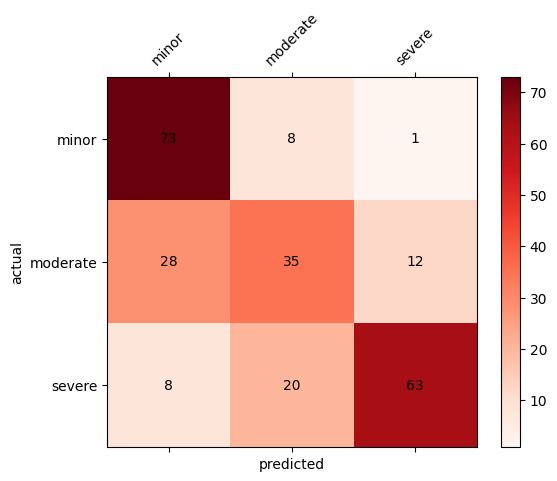

Classification Report:
              precision    recall  f1-score   support

    01-minor       0.67      0.89      0.76        82
 02-moderate       0.56      0.47      0.51        75
   03-severe       0.83      0.69      0.75        91

    accuracy                           0.69       248
   macro avg       0.68      0.68      0.68       248
weighted avg       0.69      0.69      0.68       248



In [11]:
import numpy as np
val_images, val_labels = [], []
class_names = sorted(train_generator.class_indices.keys())
for i in range(len(val_generator)):
    images, labels = val_generator[i]
    val_images.extend(images)
    val_labels.extend(np.argmax(labels, axis=1))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

predictions = inceptionv3_model.predict(val_images)

y_pred = np.argmax(predictions, axis=1)
y_true = val_labels

from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Reds')
    
cbar = fig.colorbar(cax)

ax.set_xlabel('predicted') #predicted
ax.set_ylabel('actual') #actual

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45) #predicted
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe']) #actual

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center')
print('Confusion Matrix:')

plt.show()

report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:')
print(report)

1/1 [==============================] - 0s 43ms/step


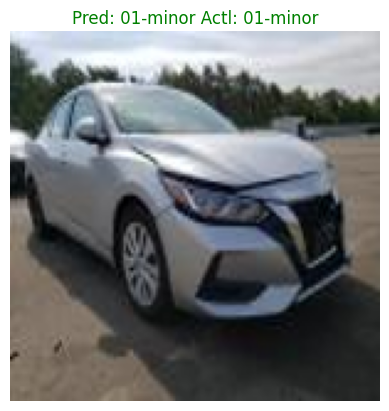

1/1 [==============================] - 0s 40ms/step


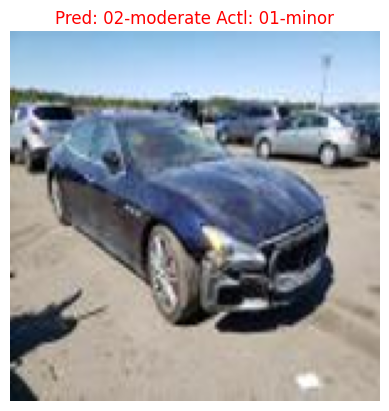

1/1 [==============================] - 0s 41ms/step


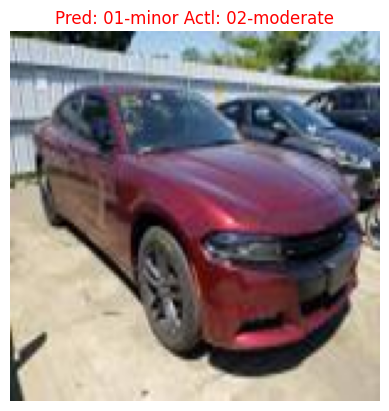

1/1 [==============================] - 0s 39ms/step


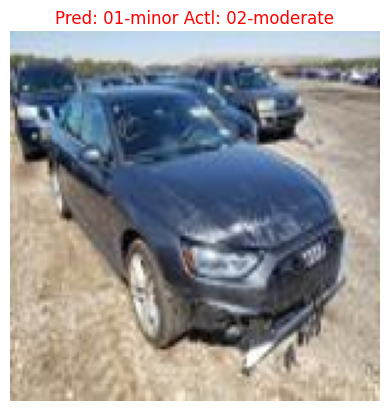

1/1 [==============================] - 0s 42ms/step


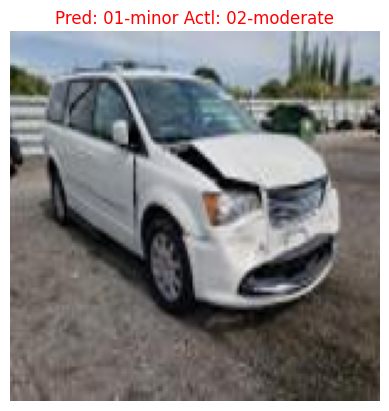

1/1 [==============================] - 0s 39ms/step


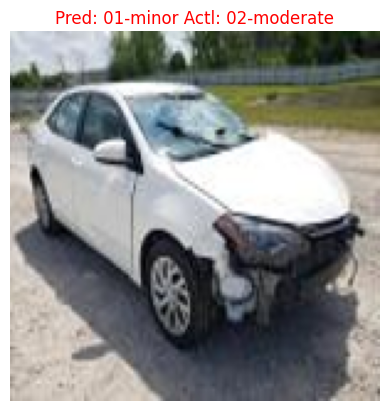

1/1 [==============================] - 0s 51ms/step


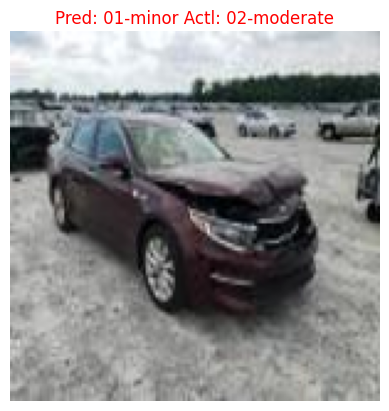

1/1 [==============================] - 0s 48ms/step


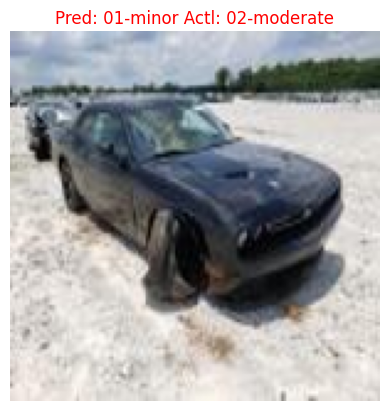

1/1 [==============================] - 0s 49ms/step


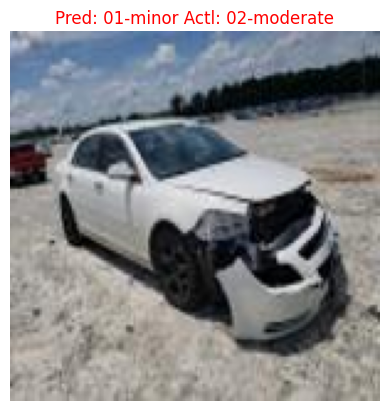

1/1 [==============================] - 0s 46ms/step


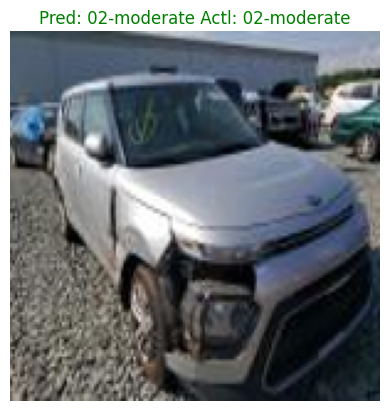

1/1 [==============================] - 0s 47ms/step


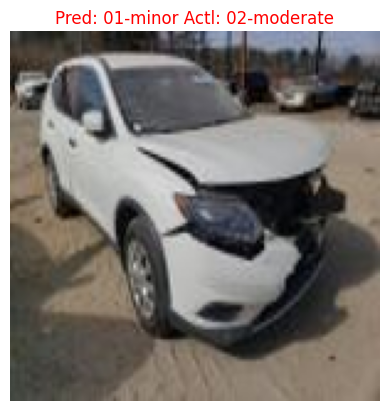

1/1 [==============================] - 0s 50ms/step


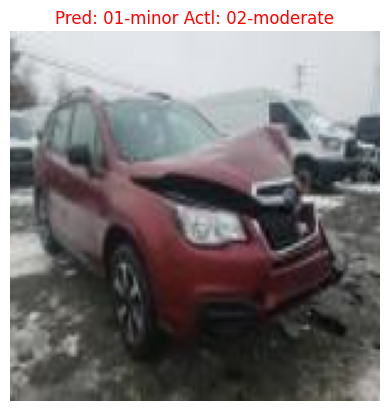

1/1 [==============================] - 0s 48ms/step


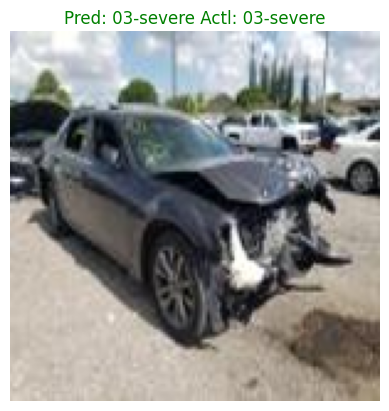

1/1 [==============================] - 0s 51ms/step


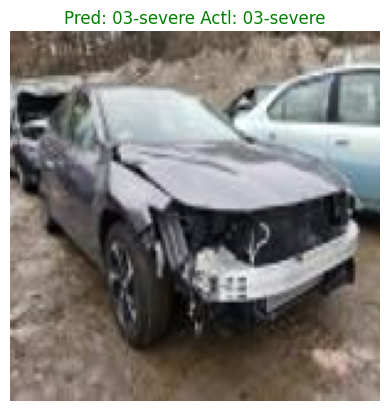

1/1 [==============================] - 0s 71ms/step


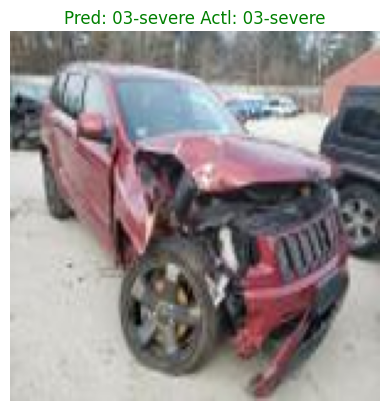

1/1 [==============================] - 0s 42ms/step


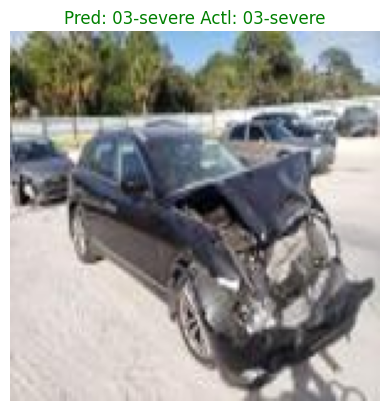

1/1 [==============================] - 0s 48ms/step


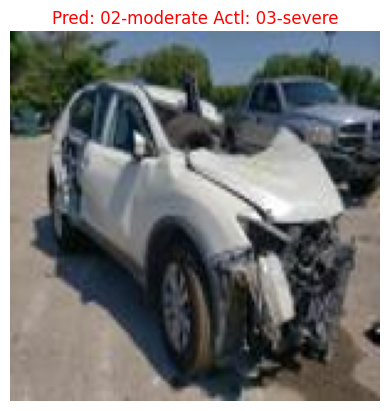

1/1 [==============================] - 0s 49ms/step


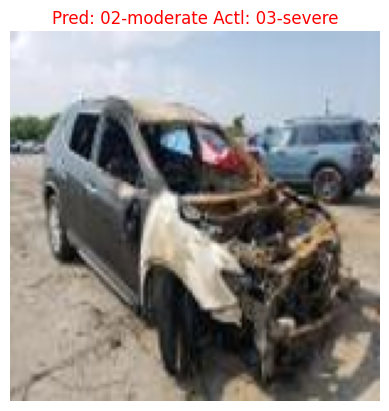

1/1 [==============================] - 0s 49ms/step


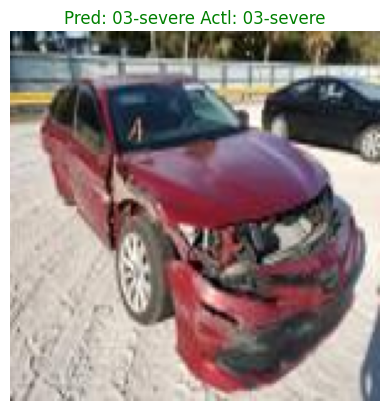

1/1 [==============================] - 0s 58ms/step


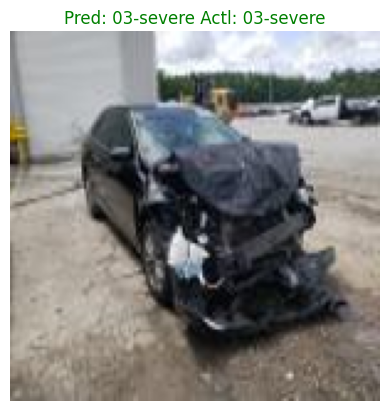

1/1 [==============================] - 0s 49ms/step


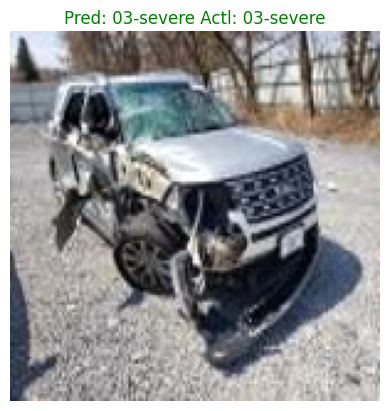

1/1 [==============================] - 0s 49ms/step


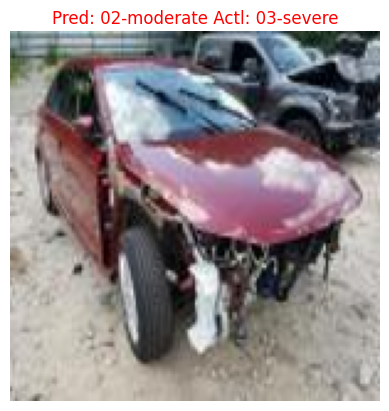

False: 13
True: 9


In [12]:
val_dir = 'data3a/validation'
class_names = ["01-minor", "02-moderate", "03-severe"]

image_paths = []
for class_name in class_names:
    folder_path = os.path.join(val_dir, class_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(folder_path, filename))
negative = 0
positive = 0
for image_path in image_paths:
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = img.resize((img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)
    pred = inceptionv3_model.predict(img)
    pred_label = class_names[np.argmax(pred)]
    folder_name = os.path.basename(os.path.dirname(image_path))
    plt.imshow(img[0])
    if (pred_label != folder_name):
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'red')
        negative+=1
    else:
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'green')
        positive+=1
   
    plt.axis('off')
    plt.show() 
print('False: '+ str(negative) + '\nTrue: ' + str(positive))

In [13]:
inceptionv3_model.save('models/inceptionv3-model-bs16-ep50-dense512.keras')
print('model saved')

model saved
